
# Clasificación de Neumonía usando Árboles de Decisión

Data set
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

En esta notebook, se presenta un ejemplo de cómo utilizar la técnica de **Árboles de Decisión** para clasificar imágenes de rayos X de tórax y diagnosticar si un paciente tiene neumonía o no.

La neumonía es una infección que inflama los alvéolos de uno o ambos pulmones, causando síntomas como tos con flema o pus, fiebre, escalofríos y dificultad para respirar. En este proyecto, vamos a entrenar modelos para analizar las imágenes de rayos X y determinar si el paciente presenta neumonía o no, lo cual es una tarea fundamental para la detección temprana y el tratamiento adecuado de esta enfermedad.


Este conjunto de datos contiene imágenes de rayos X de tórax de pacientes con neumonía y pacientes sin neumonía (imágenes normales). Los modelos se entrenarán y validarán utilizando un conjunto de datos previamente separado para cada fin.



**Explicación de las Etiquetas en los Nodos del Árbol de Decisión:**

Cuando visualizamos el árbol de decisión, podemos encontrar algunas etiquetas en los nodos que nos proporcionan información relevante sobre el proceso de clasificación:

1. **Gini impurity (Gini):** Es una medida de la impureza de un nodo. Mientras más cerca esté de cero (0), más puro es el nodo y contiene principalmente ejemplos de una sola clase. Si Gini es cercano a uno (1), el nodo contiene una mezcla de diferentes clases.

2. **Samples:** Indica el número total de ejemplos en el nodo que se están evaluando en ese paso del árbol.

3. **Value:** Muestra la distribución de las clases en el nodo. Por ejemplo, si tenemos dos clases "Normal" y "Neumonía", el valor [a, b] indicaría que hay "a" ejemplos de la clase "Normal" y "b" ejemplos de la clase "Neumonía" en ese nodo.

4. **Class:** Cuando un nodo es puramente de una sola clase, se muestra el nombre de la clase. Por ejemplo, si el nodo contiene solo ejemplos de "Neumonía", entonces la etiqueta sería "PNEUMONIA".

Es importante tener en cuenta que a medida que descendemos en el árbol, los nodos que están más cerca de la raíz son los que contienen características más generales y los que están más cerca de las hojas son los que contienen características más específicas para clasificar correctamente los ejemplos. El árbol de decisión utiliza estas etiquetas para tomar decisiones y clasificar nuevas imágenes según las características que encuentra en cada nodo.

Primer nodo del árbol de decisión:

Ejemplo: 9700 <= 0.5 Gini = 0.386 Samples = 4185 Value = [1094, 3091]


- **9700 <= 0.5:** Esta parte es la regla de decisión en el nodo. Significa que se está evaluando la característica número 9700 (una de las características extraídas de las imágenes de rayos X) y se compara si el valor de esta característica es menor o igual a 0.5. Si esta condición es verdadera para una imagen, el flujo del árbol continuará por el lado izquierdo del nodo; de lo contrario, irá por el lado derecho.

- **Gini = 0.386:** El valor de Gini impurity es una medida de cuán impuro es el nodo. En este caso, el valor de Gini impurity para este nodo es 0.386. Cuanto más cercano a cero esté este valor, más puro es el nodo, lo que significa que contiene principalmente ejemplos de una sola clase. En este caso, el valor indica que el nodo no es completamente puro, lo que sugiere que hay una mezcla de ejemplos de diferentes clases en este nodo.

- **Samples = 4185:** Indica el número total de ejemplos (imágenes de rayos X) que se están evaluando en este nodo.

- **Value = [1094, 3091]:** Muestra la distribución de las clases en el nodo. En este caso, `[1094, 3091]` significa que hay 1094 ejemplos etiquetados como "Normal" (sin neumonía) y 3091 ejemplos etiquetados como "Neumonía" en este nodo.

# 1) Descarga de dataset

In [ ]:
# Instalación de PyDrive si es necesario
!pip install -U -q PyDrive

# Autenticación en Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def authenticate_to_drive():
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    return drive

# Descargar y descomprimir archivo desde Google Drive
import zipfile

def download_and_extract_file(drive, file_id, destination_path):
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(destination_path)
    with zipfile.ZipFile(destination_path, 'r') as zip_ref:
        zip_ref.extractall("/content")

# Luego, puedes usar esta función para descargar y descomprimir archivos
# link = 'https://drive.google.com/file/d/1-7_rzUHaFmjK9IAwoduQlXmIRPgCH-m3/view?usp=sharing'
drive = authenticate_to_drive()
file_id = '1-7_rzUHaFmjK9IAwoduQlXmIRPgCH-m3'
download_and_extract_file(drive, file_id, 'PneumoniaDetection.zip')

# 2) Configuración de rutas

In [ ]:
import os
import random
import shutil

BASE_DIR = '/content/PneumoniaDetection/chest_xray/'
train_dir = os.path.join(BASE_DIR, 'train/')
val_dir = os.path.join(BASE_DIR, 'val/')
test_dir = os.path.join(BASE_DIR, 'test/')

# Función para obtener la lista de archivos de imágenes en un directorio
def get_image_files(directory):
    image_files = [os.path.join(root, file) for root, _, files in os.walk(directory) for file in files if file.endswith('.jpeg') or file.endswith('.jpg')]
    return image_files

# Obteniendo las listas de archivos de imágenes para entrenamiento y validación
training_images = get_image_files(train_dir)
validation_images = get_image_files(val_dir)

# Creando una lista de todas las imágenes
total_files = training_images + validation_images
print(f'Número total de imágenes: {len(total_files)}')

# Separando 80:20 para entrenamiento y validación
random.seed(42)
train_images = random.sample(total_files, int(0.8 * len(total_files)))
val_images = list(set(total_files) - set(train_images))

print(f'Luego de la división 80:20')
print(f'Número total de imágenes de entrenamiento: {len(train_images)}')
print(f'Número total de imágenes de validación: {len(val_images)}')

# Directorios para el nuevo conjunto de entrenamiento y validación
new_val_dataset = '/content/working/val_dataset/'
new_train_dataset = '/content/working/train_dataset/'

# Creando los directorios necesarios
os.makedirs(new_train_dataset + 'NORMAL/', exist_ok=True)
os.makedirs(new_train_dataset + 'PNEUMONIA/', exist_ok=True)
os.makedirs(new_val_dataset + 'NORMAL/', exist_ok=True)
os.makedirs(new_val_dataset + 'PNEUMONIA/', exist_ok=True)

# Copiando las imágenes a los directorios correspondientes
def copy_files_to_destination(image_list, destination):
    for ele in image_list:
        class_name = 'PNEUMONIA' if 'PNEUMONIA' in ele else 'NORMAL'
        shutil.copy(src=ele, dst=os.path.join(destination, class_name, os.path.basename(ele)))

copy_files_to_destination(train_images, new_train_dataset)
copy_files_to_destination(val_images, new_val_dataset)

print('Imágenes de rayos X de neumonía del set de entrenamiento luego de la división = ', len(os.listdir(new_train_dataset + 'PNEUMONIA/')))
print('Imágenes de rayos X normales del set de entrenamiento luego de la división = ', len(os.listdir(new_train_dataset + 'NORMAL/')))
print('Imágenes de rayos X de neumonía del set de validación luego de la división = ', len(os.listdir(new_val_dataset + 'PNEUMONIA/')))
print('Imágenes de rayos X normales del set de validación luego de la división = ', len(os.listdir(new_val_dataset + 'NORMAL/')))
print('Imágenes de rayos x de neumonía del set de testeo = ', len(os.listdir(test_dir + 'PNEUMONIA/')))
print('Imágenes de rayos x normales del set de testeo = ', len(os.listdir(test_dir + 'NORMAL/')))

Número total de imágenes: 5232
Luego de la división 80:20
Número total de imágenes de entrenamiento: 4185
Número total de imágenes de validación: 1047
Imágenes de rayos X de neumonía del set de entrenamiento luego de la división =  3120
Imágenes de rayos X normales del set de entrenamiento luego de la división =  1065
Imágenes de rayos X de neumonía del set de validación luego de la división =  763
Imágenes de rayos X normales del set de validación luego de la división =  284
Imágenes de rayos x de neumonía del set de testeo =  390
Imágenes de rayos x normales del set de testeo =  234


## Paths



In [ ]:
# Establecer las rutas para los directorios de entrenamiento, validación y prueba
train_dir = new_train_dataset
val_dir = new_val_dataset
test_dir = BASE_DIR + 'test/'

# Rutas completas para los directorios que contienen imágenes normales y de neumonía en el conjunto de entrenamiento
train_normal_dir = train_dir + 'NORMAL'
train_pneumonia_dir = train_dir + 'PNEUMONIA'

# Rutas completas para los directorios que contienen imágenes normales y de neumonía en el conjunto de validación
val_normal_dir = val_dir + 'PNEUMONIA'
val_pneumonia_dir = val_dir + 'PNEUMONIA'

# Listar los nombres de los archivos en los directorios de imágenes normales y de neumonía en el conjunto de entrenamiento
train_normal_fnames = os.listdir(train_normal_dir)
train_pneumonia_fnames = os.listdir(train_pneumonia_dir)


# 3) Visualización de datos

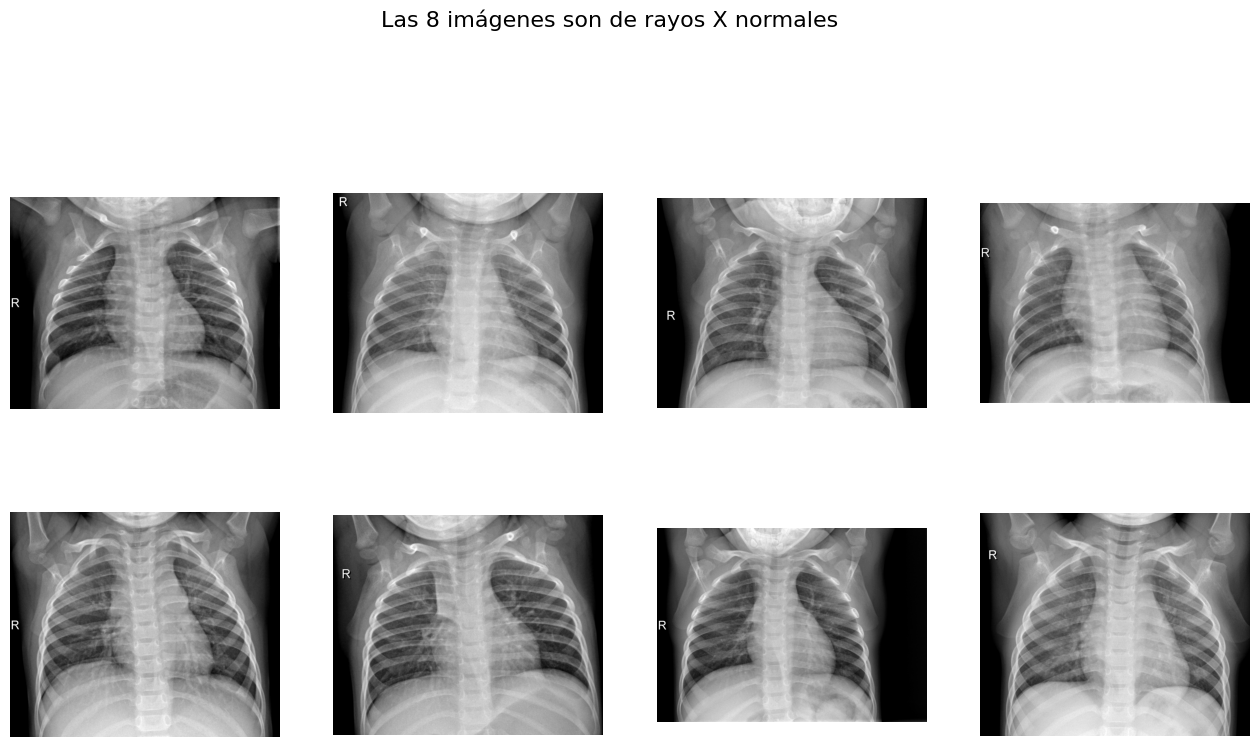

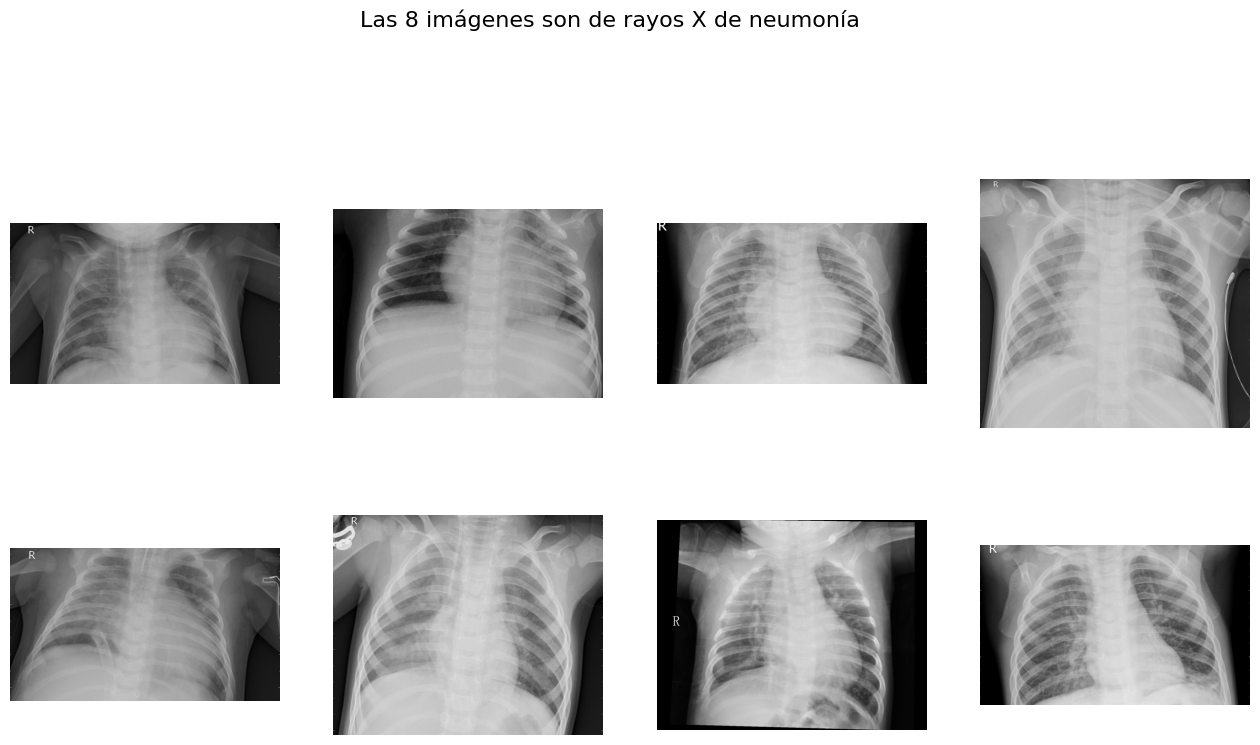

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Función para visualizar imágenes de rayos X con clasificación
def plot_images_with_classification(image_paths, no_rows, no_cols, classification, num_images_to_show):
    fig = plt.gcf()
    fig.set_size_inches(no_cols * 4, no_rows * 4)
    num_images = num_images_to_show
    image_paths = image_paths[:num_images]
    for i, img_path in enumerate(image_paths):
        sp = plt.subplot(no_rows, no_cols, i + 1)
        sp.axis('off')  # Ocultar los ejes

        img = mpimg.imread(img_path)
        plt.imshow(img, cmap='gray')

    plt.suptitle(f"Las {num_images} imágenes son de rayos X {classification}", fontsize=16)
    plt.show()

# Configuración para el gráfico
no_cols = 4
no_rows = 4

# Pedir al usuario que ingrese el número de imágenes que desea mostrar
#num_images_to_show = int(input("Ingrese el número de imágenes que desea mostrar (2, 4, 8, 16, etc.): "))
num_images_to_show = 8

# Obtener rutas completas de las primeras imágenes normales y neumonía en el conjunto de entrenamiento
normal_pix = [os.path.join(train_normal_dir, fname) for fname in train_normal_fnames[:num_images_to_show]]
pneumonia_pix = [os.path.join(train_pneumonia_dir, fname) for fname in train_pneumonia_fnames[:num_images_to_show]]

# Visualizar las imágenes de rayos X normales y de neumonía con leyenda
plot_images_with_classification(normal_pix, no_rows, no_cols, "normales", num_images_to_show)
plot_images_with_classification(pneumonia_pix, no_rows, no_cols, "de neumonía", num_images_to_show)


# 4) Modelar

4.1) instalar paquetes

In [ ]:
!pip install scikit-learn
!pip install opencv-python

4.2) Importar librerias y crear funcion features

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt

# Función para cargar las imágenes y extraer características
def load_images_and_extract_features(directory, target_size=(100, 100)):
    images = []
    labels = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, target_size)
            images.append(img.flatten())  # Aplanamos la imagen como un vector de características
            labels.append(class_name)

    return np.array(images), np.array(labels)


4.3) Dividir datos y entrenar

In [ ]:
# Cargar las imágenes y extraer características
train_images, train_labels = load_images_and_extract_features(train_dir)
val_images, val_labels = load_images_and_extract_features(val_dir)

# Crear y entrenar el árbol de decisión
tree_classifier = DecisionTreeClassifier(max_depth=5)
tree_classifier.fit(train_images, train_labels)

# Obtener la importancia de las características
feature_importance = tree_classifier.feature_importances_

4.4) Visualizar resultados

Características más importantes:
      Feature  Importance
9700     9700    0.368212
8782     8782    0.155305
7160     7160    0.121787
46         46    0.047032
469       469    0.037689

Predicion sobre el conjunto de validacion:  1047 imagenes
Precisión del árbol de decisión en el conjunto de validación: 0.8739255014326648

Informe de clasificación del árbol de decisión:
              precision    recall  f1-score   support

      NORMAL       0.81      0.70      0.75       284
   PNEUMONIA       0.89      0.94      0.92       763

    accuracy                           0.87      1047
   macro avg       0.85      0.82      0.83      1047
weighted avg       0.87      0.87      0.87      1047


Matriz de confusión:
[[199  85]
 [ 47 716]]


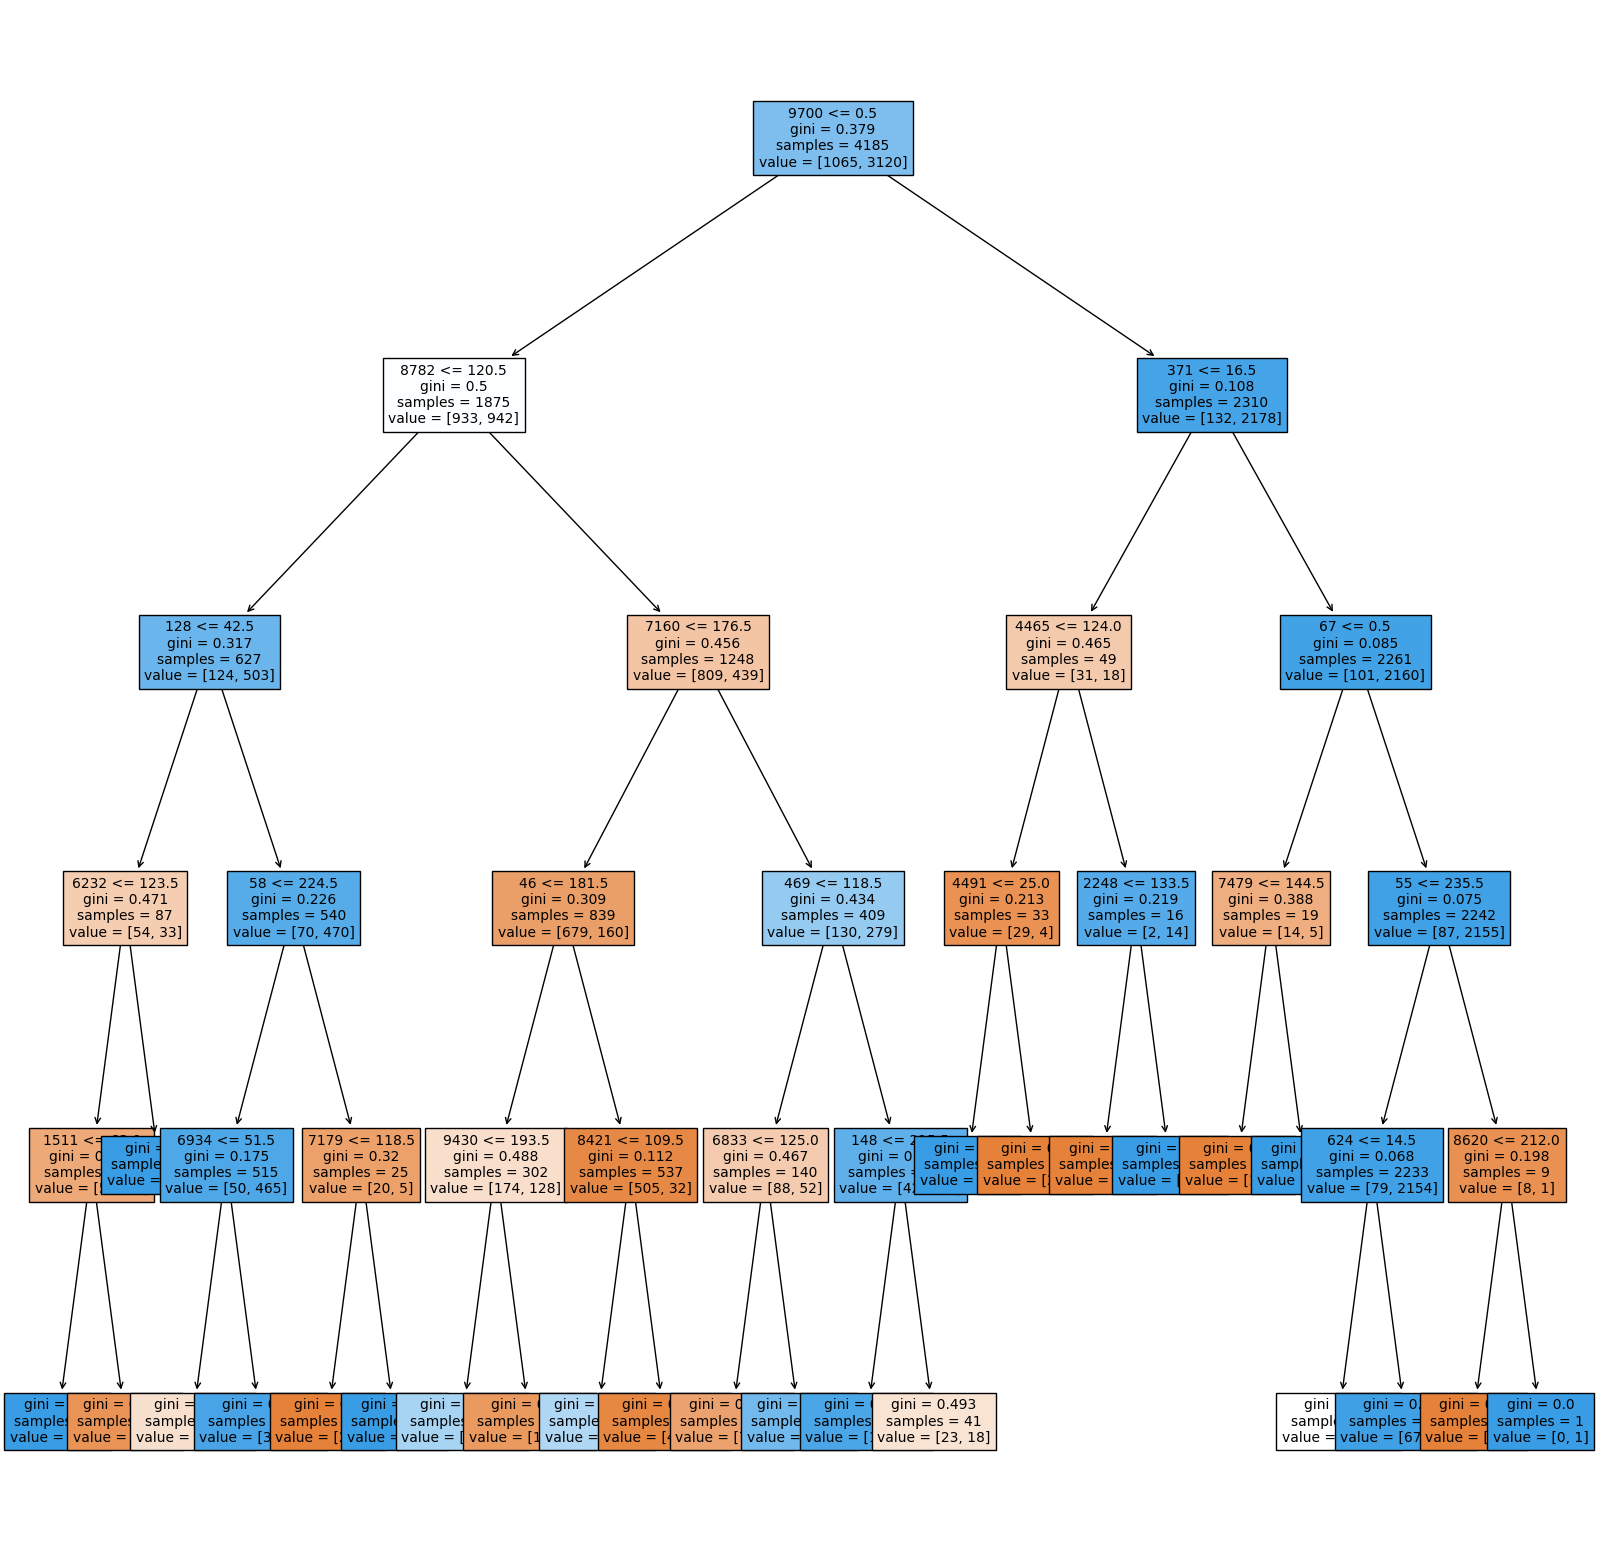


Tabla comparativa de valores reales y predichos:
  Valor Real Valor Predicho
0     NORMAL         NORMAL
1     NORMAL      PNEUMONIA
2     NORMAL      PNEUMONIA
3     NORMAL         NORMAL
4     NORMAL         NORMAL
5     NORMAL      PNEUMONIA
6     NORMAL         NORMAL
7     NORMAL         NORMAL
8     NORMAL         NORMAL
9     NORMAL         NORMAL


In [ ]:

# Crear un dataframe para mostrar la importancia de las características
feature_df = pd.DataFrame({'Feature': np.arange(len(feature_importance)), 'Importance': feature_importance})

# Ordenar el dataframe por importancia descendente
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Mostrar las características más importantes
print("Características más importantes:")
print(feature_df.head())

# Realizar predicciones en el conjunto de validación
val_predictions = tree_classifier.predict(val_images)
print("\nPredicion sobre el conjunto de validacion: ", len(val_images), "imagenes")

# Evaluar el rendimiento del árbol de decisión
accuracy = accuracy_score(val_labels, val_predictions)
print("Precisión del árbol de decisión en el conjunto de validación:", accuracy)

# Mostrar el informe de clasificación
print("\nInforme de clasificación del árbol de decisión:")
print(classification_report(val_labels, val_predictions))

# Crear matriz de confusión
conf_matrix = confusion_matrix(val_labels, val_predictions)
print("\nMatriz de confusión:")
print(conf_matrix)

# Visualizar el árbol de clasificación
plt.figure(figsize=(20, 20))
tree.plot_tree(tree_classifier, filled=True, feature_names=[str(i) for i in range(train_images.shape[1])], fontsize=10)
plt.show()

# Realizar predicciones en el conjunto de validación con el árbol podado
val_predictions_poda = tree_classifier.predict(val_images[:10])

# Crear una tabla comparativa con los valores reales y predichos
comparacion_df = pd.DataFrame({'Valor Real': val_labels[:10], 'Valor Predicho': val_predictions_poda})

print("\nTabla comparativa de valores reales y predichos:")
print(comparacion_df)

### <font color='red'> Tarea 1 </font>
Identificar las librerías utilizadas en la construcción de un AD


### <font color='red'> Tarea 2 </font>
Crear un 2do modelo de AD, modificar los siguientes hiperparámetros:  
- criterion= entropy
- splitter = “best”,
- max depth: 4
- min_samples_split

### <font color='red'> Tarea 3 </font>
Dividir el conjunto: test 70%, train 15%, val 15%


### <font color='red'> Tarea 4 </font>
Aplicar cross-validation


### <font color='red'> Tarea 5 </font>
Comparar los resultados de los 2 modelos AD.


### <font color='red'> Tarea 6 </font>
Argumentar la elección del modelo


